# Import Packages

In [1]:
import numpy as np
import evaluate
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoTokenizer
import torch
from datasets import Dataset
from typing import Optional

c:\Users\Jon\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Tokenize dataset and 2. Train Test Splitting

In [2]:
tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
def preprocess_function(examples):
    return tokenizer(examples["text"], padding='max_length', truncation=True)

In [4]:
TRAINING_DATA = pd.read_csv('../ner/jonpg_prepped_data.csv')[['headlines','label']]
print(len(TRAINING_DATA))
text = TRAINING_DATA['headlines'].tolist()

labels = TRAINING_DATA['label'].tolist()


# Split another testing set in case I want to do my own testing
# text_train, text_test, label_train, label_test = train_test_split(
#     train_text, train_label, test_size=0.10, random_state=42)
training_text, testing_text, training_labels, testing_labels = train_test_split(
    text, labels, test_size=0.20, random_state=42)

train_dataset = Dataset.from_dict({'text':training_text, 'label':training_labels})
eval_dataset = Dataset.from_dict({'text':testing_text, 'label':testing_labels})

tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_val = eval_dataset.map(preprocess_function, batched=True)

45463


Map: 100%|██████████| 9093/9093 [00:00<00:00, 9133.18 examples/s]


# 3. Fine-tune Data to the Model

In [5]:
model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis", num_labels=3)
model.config.id2label = {0:'decrease', 1:'sustain',2:'increase'}

In [7]:
training_args = TrainingArguments(
    output_dir='C:/Users/Jon/Documents/Career/Projects/SDSPNLP/results',
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val
)

In [8]:
trainer.train()
trainer.save_model('C:/Users/Jon/Documents/Career/Projects/SDSPNLP/results/jonpg_model')

 22%|██▏       | 500/2274 [3:16:25<11:35:23, 23.52s/it]

{'loss': 1.1502, 'grad_norm': 2.401078462600708, 'learning_rate': 2.3403693931398417e-05, 'epoch': 0.22}


 44%|████▍     | 1000/2274 [6:18:51<7:38:13, 21.58s/it]

{'loss': 1.0999, 'grad_norm': 2.466158390045166, 'learning_rate': 1.6807387862796836e-05, 'epoch': 0.44}


 66%|██████▌   | 1500/2274 [9:17:11<4:43:32, 21.98s/it]

{'loss': 1.0914, 'grad_norm': 1.3107244968414307, 'learning_rate': 1.0211081794195251e-05, 'epoch': 0.66}


 88%|████████▊ | 2000/2274 [12:16:25<1:37:08, 21.27s/it]

{'loss': 1.0925, 'grad_norm': 2.427618980407715, 'learning_rate': 3.6147757255936676e-06, 'epoch': 0.88}


100%|██████████| 2274/2274 [13:55:14<00:00, 22.04s/it]  

{'train_runtime': 50114.8865, 'train_samples_per_second': 0.726, 'train_steps_per_second': 0.045, 'train_loss': 1.10621349163609, 'epoch': 1.0}


# 4. Create an Inference Function

In [1]:
import re
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

def model_call(
        inputs: list,
        return_probability: bool = True):
    """model_call takes in 
    parameter:inputs -> string or list of strings 
    and outputs the jonpg_model 
    results: tensor(decrease, sustain, increase)
    
    output_max_prob will return the probabilities and their respective classes."""

    # First we need to clean the data 
    def replace_currency_symbols(text):
    # Dictionary mapping currency symbols to their acronyms
        currency_dict = {
            '£': 'GBP ',   # British Pound
            '€': 'EUR ',   # Euro
            '$': 'USD ',   # US Dollar
            '¥': 'JPY ',   # Japanese Yen
            '₹': 'INR ',   # Indian Rupee
            '₽': 'RUB ',   # Russian Ruble
            '₩': 'KRW ',   # South Korean Won
            '฿': 'THB ',   # Thai Baht
            '₺': 'TRY ',   # Turkish Lira
            '₪': 'ILS '    # Israeli Shekel
        }

        # Regular expression pattern to match any of the currency symbols
        pattern = re.compile('|'.join(re.escape(symbol) for symbol in currency_dict.keys()))

        # Function to replace a matched symbol with its acronym
        def replace_symbol(match):
            return currency_dict[match.group(0)]

        # Replace all currency symbols in the text
        return pattern.sub(replace_symbol, text)
    def clean_text(text):
        # Add a space before and after punctuation marks
        text = re.sub(r'([.,!?;:])', r' \1 ', replace_currency_symbols(text))
        
        # Remove newlines and tabs
        text = text.replace('\n', ' ').replace('\t', ' ')
        
        # Remove any extra spaces that might have been introduced
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    model = AutoModelForSequenceClassification.from_pretrained('C:/Users/Jon/Documents/Career/Projects/SDSPNLP/results/jonpg_model')
    tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
    # Run the str or list through the clean text function
    if type(inputs) == str:
        inputs = clean_text(inputs)
        
        tv = torch.tensor([tokenizer.encode(inputs, padding="max_length", max_length=64, truncation=True)])
    else:
        inputs = [clean_text(i) for i in inputs]
        
        tv = torch.tensor([tokenizer.encode(x, padding="max_length", max_length=64, truncation=True) for x in inputs])
    

    # Now call in the model from file with tokenize cleaned inputs
    attention_mask = (tv != 0).type(torch.int64)
    # Grab logits or probabilities and return them
    outputs = model(tv, attention_mask=attention_mask)[0].detach().cpu()

    if return_probability:
        outputs = torch.sigmoid(outputs)

    return outputs.numpy()
        

c:\Users\Jon\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Examples

In [2]:
model_call(inputs=['Stocks are going up $$$$$$$$$$$$$$$!!!!', 'something weird is up with Cramer.'], return_probability=False)

array([[ 0.02425274, -0.00695869,  0.02736503],
       [ 0.02038652,  0.0454974 , -0.02326715]], dtype=float32)

In [3]:
model_call(inputs='something is going on in the stock market .', return_probability=True)

array([[0.50625896, 0.51019675, 0.4976106 ]], dtype=float32)

# Model Explanation

In [4]:
# Run model_call with necassary packages first
import shap
tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

In [5]:
labels = [
    'decrease',
    'sustain',
    'increase'
]


In [6]:
explainer = shap.Explainer(model_call, tokenizer, output_names=labels)

In [7]:
text_example = ['Stocks are going up $$$$$$$$$$$$$$$!!!!', 'something weird is up with Cramer.', 'something is going on in the stock market .']

shap_values = explainer(text_example)

PartitionExplainer explainer: 4it [00:48, 16.04s/it]                       


In [8]:
shap.plots.text(shap_values)

# NER with spaCy (Py 3.11)

In [1]:
import json
def load_data(file):
    with open(file, "r", encoding="utf-8") as f:
        data = json.load(f)
    return data

In [2]:
import json
def write_data(file, data):
    with open(file, "w", encoding="utf-8") as f:
        json.dump(data, f, indent = 4)

In [3]:
import re
def clean(text):
    out = []
    for line in text:
        out.append(re.sub(r'[^a-zA-Z0-9\']+', ' ', line).replace("'",'').strip())
    return out
    
    


# Prepping and Loading Data

In [50]:
import pandas as pd

companies = pd.read_csv('ner/sp500_company_info.csv').dropna()
print(companies.columns)
sym = companies['Symbol'].tolist()
name = companies['Security'].tolist()
sector = companies['GICSSector'].tolist()
industry = companies['GICS Sub-Industry'].tolist()
location = companies['Headquarters Location'].tolist()
founded = companies['Founded'].tolist()

companies = {'symbol': sym, 
             'name':name,
             'sector':sector,
             'industry':industry,
             'location':location,
             'founded':founded}
write_data('ner/companies.json',companies)

Index(['Symbol', 'Security', 'GICSSector', 'GICS Sub-Industry',
       'Headquarters Location', 'Founded'],
      dtype='object')


In [51]:
import pandas as pd

companies = pd.read_csv('ner/exchange_info.csv').dropna()
print(companies.columns)
exchange = companies['Stock exchange'].tolist()
mic = companies['MIC'].tolist()
region = companies['Region'].tolist()
city = companies['City'].tolist()
# location = companies['Headquarters Location'].tolist()
# founded = companies['Founded'].tolist()

companies = {'exchange': exchange, 
             'mic':mic,
             'region':region,
             'city':city}
write_data('ner/exchange.json',companies)

Index(['Stock exchange', 'MIC', 'Region', 'City'], dtype='object')


In [5]:
exchange = load_data('ner/exchange.json')
exchange = exchange['exchange'] + exchange['mic']
exchange = clean(exchange)
write_data('ner/exchange_train.json',exchange)

In [6]:
comp = load_data('ner/companies.json')
comp = comp['symbol'] + comp['name']
comp = clean(comp)
write_data('ner/companies_train.json', comp)

In [7]:
comp = load_data('ner/companies.json')
comp = comp['industry'] + comp['sector']
comp = clean(comp)
write_data('ner/industry_train.json', comp)

In [9]:
comp = load_data('ner/companies.json')
exchange = load_data('ner/exchange.json')
gpe = comp['location'] + exchange['region'] + exchange['city']
gpe = clean(gpe)
write_data('ner/gpe_train.json',gpe)

In [10]:
text = load_data('ner/ner_headlines.json')


In [71]:
count = 0
for segment in text:
    words = segment.split()
    for word in words:
        if word in gpe:
            
            count += 1
count/len(text)

0.1140211472040345

In [72]:
count

5381

## Example NER with pipeline features

In [13]:
text = text[:10]
text = ' '.join(text)

In [14]:
import spacy
from spacy.lang.en import English
from spacy.pipeline import EntityRuler
import random
from spacy.tokens import span


In [15]:
nlp = spacy.load("en_core_web_lg")

c:\Users\Jon\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
doc = nlp(text)

In [17]:
for ent in doc.ents:
    print(ent.text, ent.label_)

Jim Cramer PERSON
19 CARDINAL
TeradyneCramers PERSON
vaccinesIQ CARDINAL
Keith Bliss PERSON
healthcare ORG
Jim Cramer PERSON
Cramers PERSON
Wex Acorns ORG
5 MONEY
five CARDINAL
Dividend ORG
StockX ORG
1 million CARDINAL
Jordan GPE
this year DATE
Biohaven Pharmaceuticals ORG
Khloe Kardashian PERSON
Cramers ORG
Cramers ORG
Tuesdays DATE
Jim Cramer PERSON


In [18]:
nlp.add_pipe('ner', name='camp_ner')

In [20]:
nlp.add_pipe('ner', name='ghetto_ner', before='lemmatizer')

In [21]:
nlp.add_pipe('ner', name='city_ner', after='parser')

In [22]:
# Order matters, spacy will apply each pipe and find entities depending on the order
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'city_ner',
 'attribute_ruler',
 'ghetto_ner',
 'lemmatizer',
 'ner',
 'camp_ner']

# Create Training Data


In [23]:
def create_training_data(file, type):
    data = load_data(file)
    patterns = []
    for item in data:
        pattern = {
            'label': type,
            'pattern': item
        }
        patterns.append(pattern)
    return patterns


In [25]:
patterns = (create_training_data('ner/companies_train.json', 'company') + 
            create_training_data('ner/exchange_train.json', 'exchange') + 
            create_training_data('ner/gpe_train.json', 'gpe') + 
            create_training_data('ner/industry_train.json','industry')
)

In [73]:
patterns[:10] 

[{'label': 'company', 'pattern': 'MMM'},
 {'label': 'company', 'pattern': 'AOS'},
 {'label': 'company', 'pattern': 'ABT'},
 {'label': 'company', 'pattern': 'ABBV'},
 {'label': 'company', 'pattern': 'ACN'},
 {'label': 'company', 'pattern': 'ADBE'},
 {'label': 'company', 'pattern': 'AMD'},
 {'label': 'company', 'pattern': 'AES'},
 {'label': 'company', 'pattern': 'AFL'},
 {'label': 'company', 'pattern': 'APD'}]

In [27]:

nlp = spacy.blank('en')
ruler = nlp.add_pipe('entity_ruler')
ruler.add_patterns(patterns)
nlp.to_disk('ner/sp_500_ner')


In [29]:
text = load_data('ner/ner_headlines.json')

In [74]:
text[:10]

['Jim Cramer A better way to invest in the Covid 19 vaccine gold rushCramers lightning round I would own TeradyneCramers week ahead Big week for earnings even bigger week for vaccinesIQ Capital CEO Keith Bliss says tech and healthcare will rallyWall Street delivered the kind of pullback Ive been waiting for  Jim Cramer says',
 'Cramers lightning round I would just stay long Wex',
 'Acorns CEO Parents can turn USD 5 into five figures for their kids through power of compounding',
 'Dividend cuts may mean rethinking your retirement income strategy',
 'StockX has authenticated 1 million Jordan sneakers this year CEO says',
 'Biohaven Pharmaceuticals lands Khloe Kardashian as influencer of new migraine drug',
 'Cramers lightning round I like Beyond Meat',
 'Cramer We desperately need another round of federal stimulus despite vaccine progress',
 'Cramers lightning round Buy more VMware',
 'Wall Street did something highly unusual in Tuesdays session Jim Cramer says']

In [31]:
def test_model(model, text):
    doc = model(text)
    results = []
    entities = []
    for ent in doc.ents:
        entities.append((ent.start_char, ent.end_char, ent.label_))
    if len(entities) > 0:
        results = [text, {'entities': entities}]
        return results


In [33]:
nlp = spacy.load("ner/sp_500_ner")

TRAIN_DATA = []
for segment in text:
    results = test_model(nlp, segment)
    if results != None:
        TRAIN_DATA.append(results)

In [76]:
# TRAIN_DATA = [(text, {'entities': [(start, end, label)]})]

TRAIN_DATA[:3]

[['B of A Securities Maintains Neutral on Agilent Technologies Raises Price Target to 88',
  {'entities': [(39, 59, 'company')]}],
 ['CFRA Maintains Hold on Agilent Technologies Lowers Price Target to 85',
  {'entities': [(23, 43, 'company')]}],
 ['UBS Maintains Neutral on Agilent Technologies Raises Price Target to 87',
  {'entities': [(25, 45, 'company')]}]]

In [34]:
write_data('ner/TRAINING_DATA.json', TRAIN_DATA)

In [35]:
TRAINING_DATA = load_data('ner/TRAINING_DATA.json')

In [77]:
train = TRAINING_DATA[:int(len(TRAINING_DATA)*.8)]
valid = TRAINING_DATA[int(len(TRAINING_DATA)*.8):]
valid[:3]

[['Factbox Foreign investment in Saudi Arabia',
  {'entities': [[30, 42, 'gpe']]}],
 ['Boeing raises profit and sales forecast shares jump',
  {'entities': [[0, 6, 'company']]}],
 ['Saudi Arabia reassures boycotting banks prince to address forum',
  {'entities': [[0, 12, 'gpe']]}]]

In [37]:
from spacy.tokens import DocBin
import spacy
import json
from tqdm import tqdm
import random
nlp = spacy.blank('en')
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot['entities']:
            span = doc.char_span(start, end, label = label, alignment_mode='contract')
            if span is None:
                print("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return db

In [38]:
train = create_training(train)

100%|██████████| 9362/9362 [00:00<00:00, 12185.86it/s]


In [39]:
train.to_disk('./ner/train.spacy')

In [40]:
valid = create_training(valid)
valid.to_disk('./ner/valid.spacy')

100%|██████████| 2341/2341 [00:00<00:00, 18566.41it/s]


## Use Command Line now to train NER Model

Once you have train.spacy and valid.spacy, go to https://spacy.io/usage/training

Select the parameters you want and copy the spacy generated text


Create an empty 'base_config.cfg' file and paste in the text

Now pass the following command that will look like this:
    python -m spacy init fill-config base_config.cfg config.cfg

This will create the 'config.cfg' file, make sure you are in the right directory or using the correct filepaths

To train the model, use this command:
    python -m spacy train config.cfg --output ./output

This will put last_model and best_model in you output folder


# Evaluate Model

In [41]:
import pandas as pd

In [57]:
testing_data = pd.read_csv('ner/output/analyst_ratings_processed.csv')['title'].tolist()
testing_data = clean(testing_data)

In [59]:
write_data('ner/output/testing_data.json',testing_data)

In [79]:
docs = load_data('ner/output/testing_data.json')


In [80]:
nlp = spacy.load('ner/output/model-last')

In [81]:
for headline in docs[3050:3150]:
    
    doc = nlp(headline)
    if doc.ents:
        print(headline)
        for ent in doc.ents:
            print(ent.text, ent.label_)
        print('\n')

Stocks That Made New 52 Week Highs Earlier Today Include Pfizer AES Simon Property Group HCA Healthcare Church Dwight Kellogg Advanced Auto Parts McCormick Target OReilly Automotive Ross Stores Mosaic and CF Industries
Pfizer company
HCA company
Advanced Auto Parts company
Ross Stores company


Stocks Making 52 Week Highs In Todays Session Include Centene OReilly Automotive Tiffany Align Technology Fidelity National Info Norfolk Southern CSX W W Grainger Advance Auto Parts Sysco Humana Cintas Costco and HCA Healthcare
CSX company
Sysco company
Cintas company
Costco company
HCA company


5 Biggest Price Target Changes For Friday
Biggest Price company


Argus Maintains Buy on Advance Auto Parts Raises Price Target to 155
Parts Raises Price company


Bank of America Maintains Underperform on Advance Auto Parts Raises Price Target to 103
Bank of America company
Parts Raises Price company


Stocks That Made New 52 Week Highs Today Include Netflix Twenty First Century Fox Advance Auto Parts 

In [68]:
nlp_ruler = spacy.load("ner/sp_500_ner")

TRAIN_DATA = []
for segment in docs:
    results = test_model(nlp_ruler, segment)
    if results != None:
        TRAIN_DATA.append(results)
docs = TRAIN_DATA
docs[0]

['B of A Securities Maintains Neutral on Agilent Technologies Raises Price Target to 88',
 {'entities': [(39, 59, 'company')]}]

(array([[129757,   1648,     76,    101,     60],
        [  4305,  10753,      0,      1,     37],
        [     0,      1,     53,      0,      0],
        [    25,      2,      1,    633,      0],
        [   495,     11,      2,      0,   2516]], dtype=int64),
 <Axes: title={'center': 'Confusion Matrix, for SpaCy NER'}, xlabel='Predicted label', ylabel='True label'>,
 <module 'matplotlib.pyplot' from 'c:\\Users\\Jon\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\matplotlib\\pyplot.py'>)

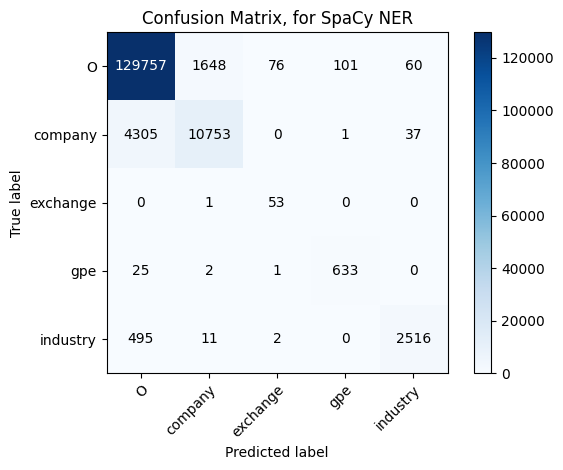

In [70]:
from spacy.training import offsets_to_biluo_tags
def get_cleaned_label(label: str):
    if "-" in label:
        return label.split("-")[1]
    else:
        return label
    
def create_total_target_vector(docs):
    target_vector = []
    for doc in docs:
        # print (doc)
        new = nlp.make_doc(doc[0])
        entities = doc[1]["entities"]
        bilou_entities = offsets_to_biluo_tags(new, entities)
        final = []
        for item in bilou_entities:
            final.append(get_cleaned_label(item))
        target_vector.extend(final)
        
    return target_vector
def create_prediction_vector(text):
    return [get_cleaned_label(prediction) for prediction in get_all_ner_predictions(text)]

def create_total_prediction_vector(docs: list):
    prediction_vector = []
    for doc in docs:
        prediction_vector.extend(create_prediction_vector(doc[0]))
    return prediction_vector

def get_all_ner_predictions(text):
    doc = nlp(text)
    entities = [(e.start_char, e.end_char, e.label_) for e in doc.ents]
    bilou_entities = offsets_to_biluo_tags(doc, entities)
    return bilou_entities
def get_model_labels():
    labels = list(nlp.get_pipe("ner").labels)
    labels.append("O")
    return sorted(labels)
def get_dataset_labels():
    return sorted(set(create_total_target_vector(docs)))
# sorted(set(create_total_target_vector(docs)))
from sklearn.metrics import confusion_matrix

def generate_confusion_matrix(docs): 
    classes = sorted(set(create_total_target_vector(docs)))
    y_true = create_total_target_vector(docs)
    # print(y_true)
    y_pred = create_total_prediction_vector(docs)
    # print(y_pred)
    return confusion_matrix(y_true, y_pred)
# generate_confusion_matrix(docs)
from matplotlib import pyplot
import numpy

def plot_confusion_matrix(docs, classes, normalize=False, cmap=pyplot.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
   
    title = 'Confusion Matrix, for SpaCy NER'

    # Compute confusion matrix
    cm = generate_confusion_matrix(docs)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]

    fig, ax = pyplot.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=numpy.arange(cm.shape[1]),
           yticks=numpy.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    pyplot.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return cm, ax, pyplot
plot_confusion_matrix(docs,classes=get_dataset_labels(),normalize=False)